#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. 
Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 
**Задача** - построить модель для такого предсказания.
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
1. Проанализировать данные.
1. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
1. Проверить данные на тестовой выборке и сделать выводы.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

## Подготовка

In [5]:
data = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])
data.sort_index(inplace=True)
data.head(12)

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
2018-03-01 00:50:00          21
2018-03-01 01:00:00           7
2018-03-01 01:10:00           5
2018-03-01 01:20:00          17
2018-03-01 01:30:00          12
2018-03-01 01:40:00          19
2018-03-01 01:50:00          25

In [6]:
data = data.resample('1H').sum()
data.head()

/tmp/ipykernel_74980/1331465909.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('1H').sum()


num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

## Анализ

In [7]:
# диапазон дат
data.index[0], data.index[-1]

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:00:00'))

Данные за период март 2018 - август 2018

In [8]:
# заказы
data.describe()

num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000

От 0 до 462 заказов в час, 84 в среднем. Похоже на правду.

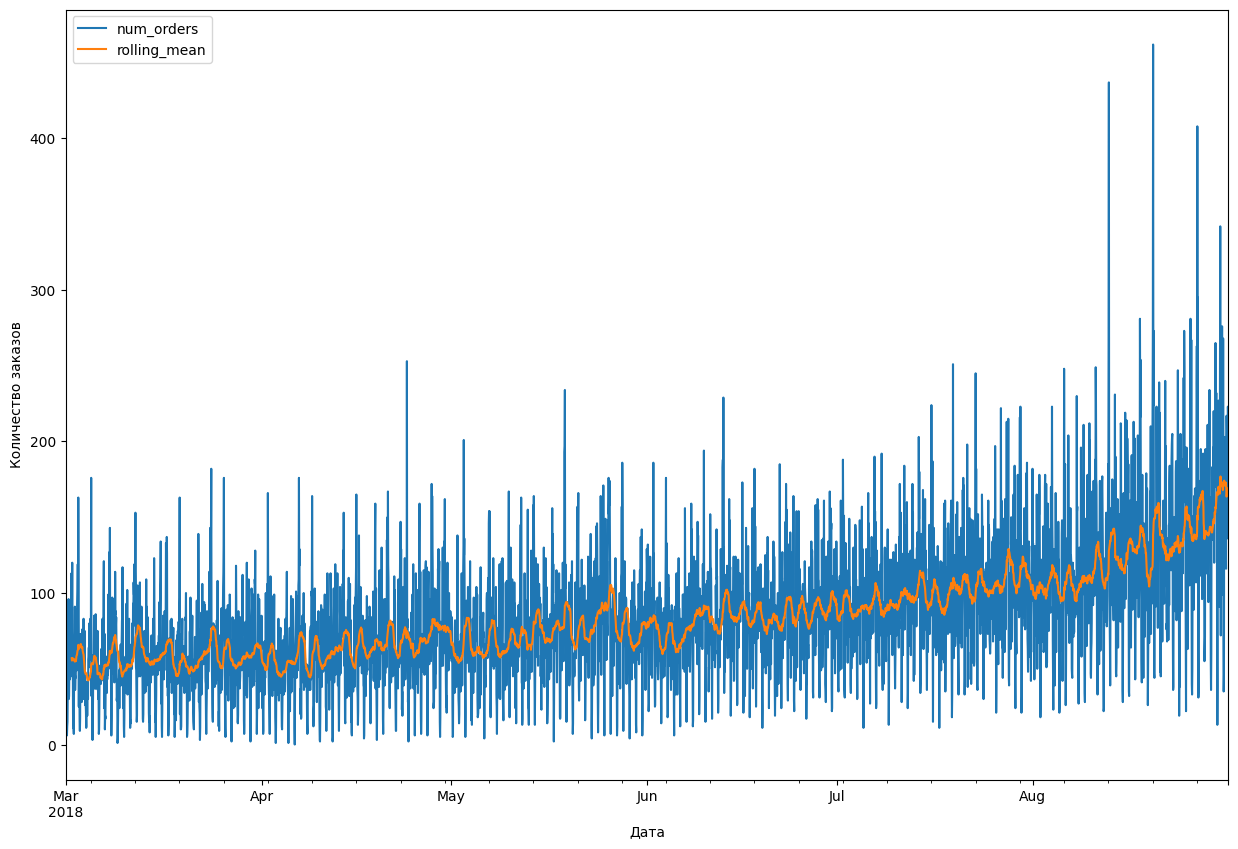

In [9]:
# добавим скользящее среднее за сутки и посмотрим график
data['rolling_mean'] = data.rolling(24).mean()
data.plot(figsize=(15, 10))
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.show()

Не очень понятно - посмотрим по месяцам

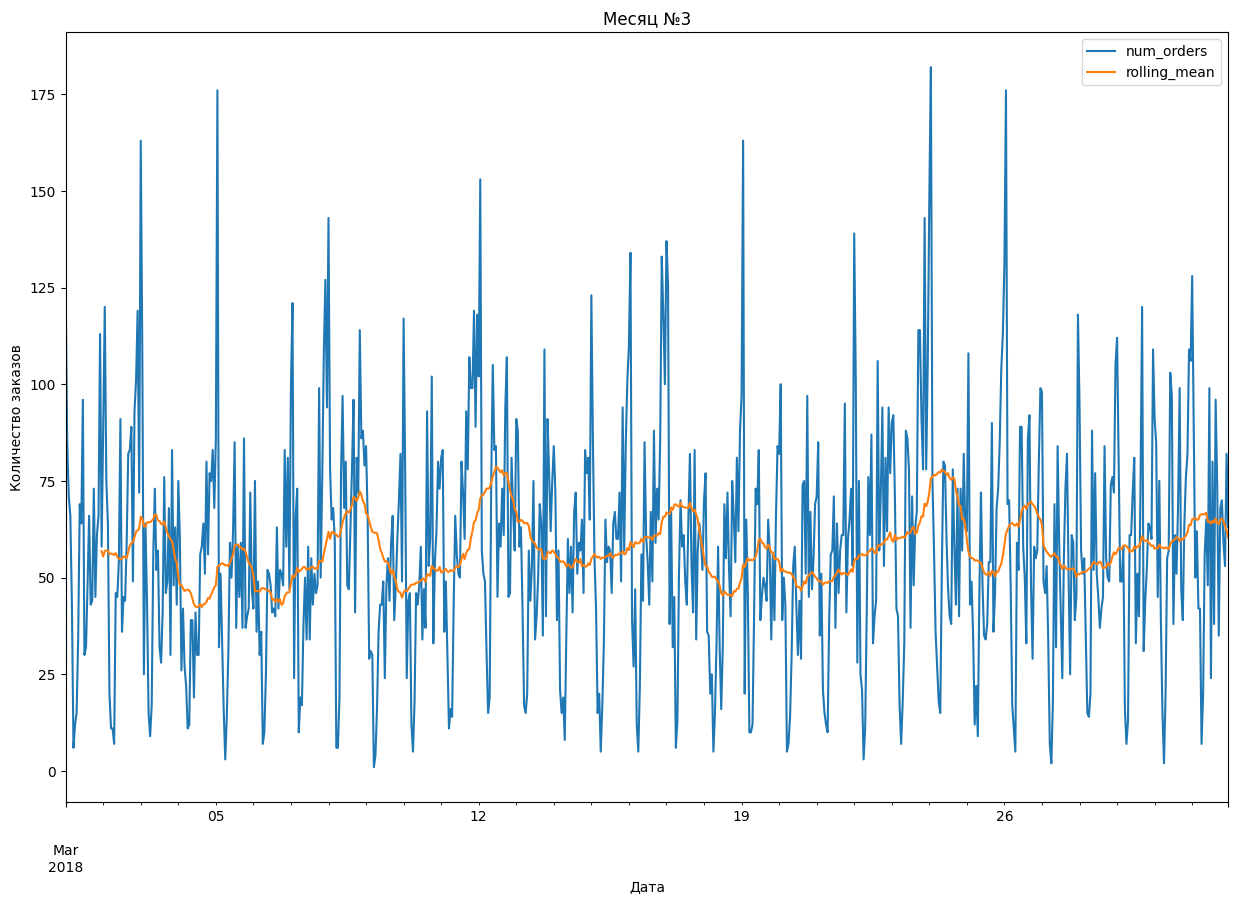

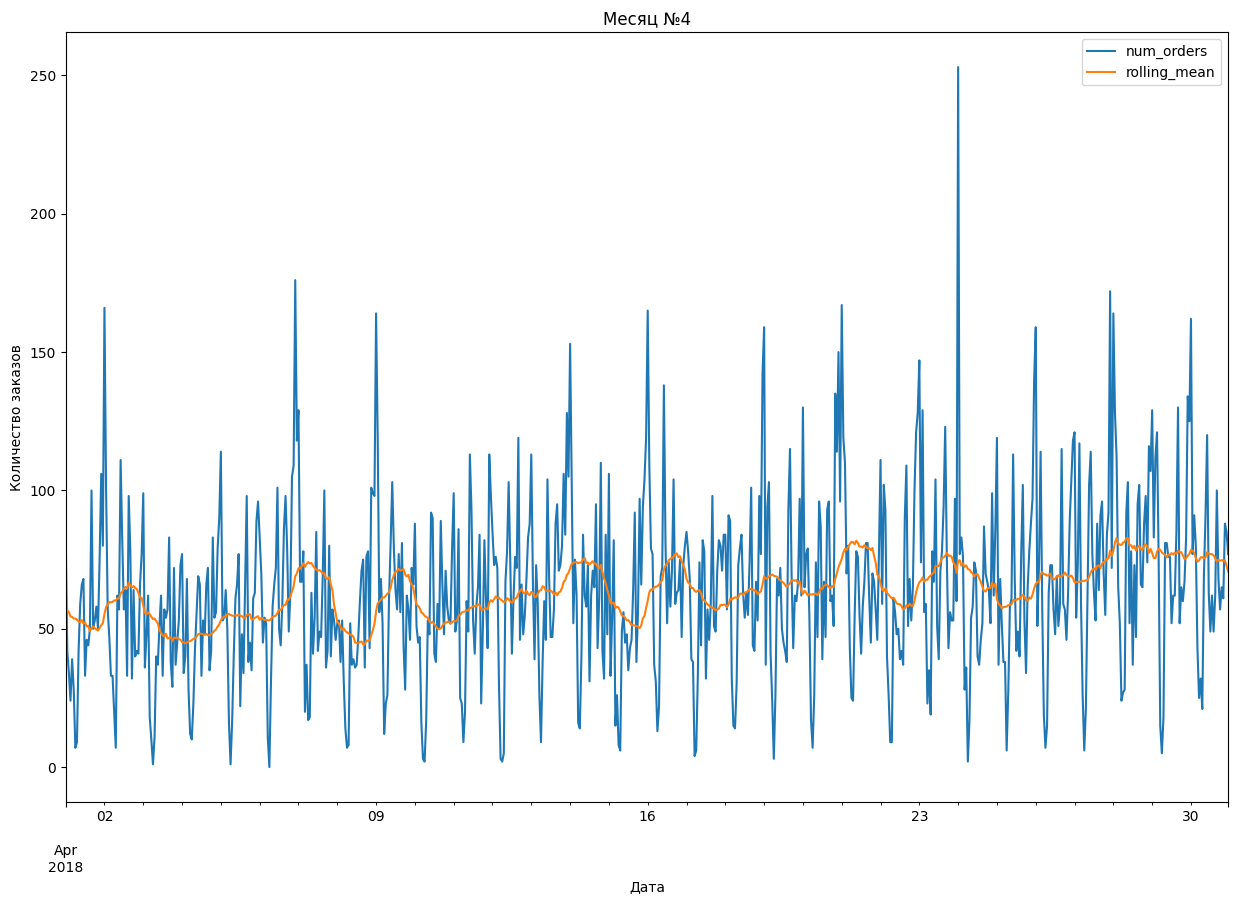

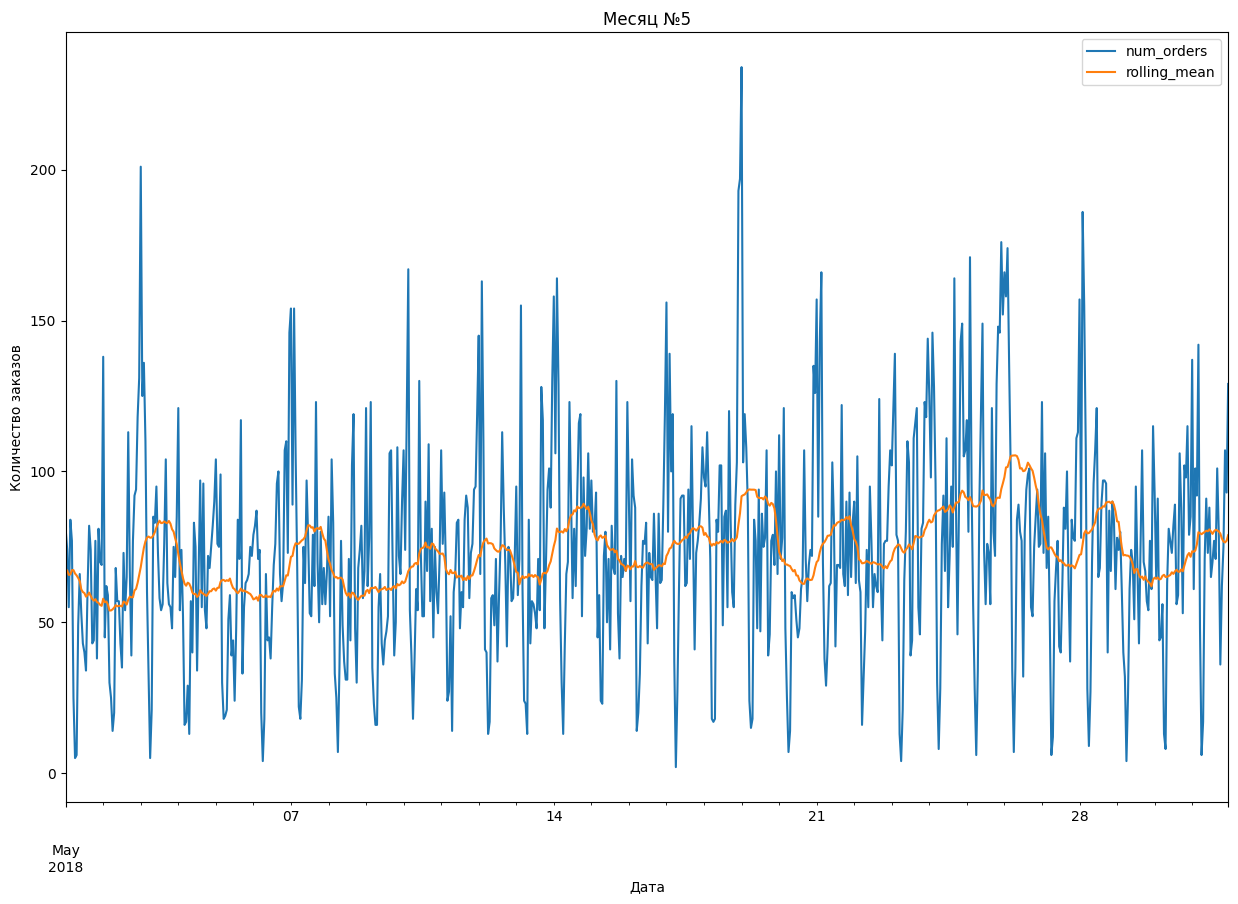

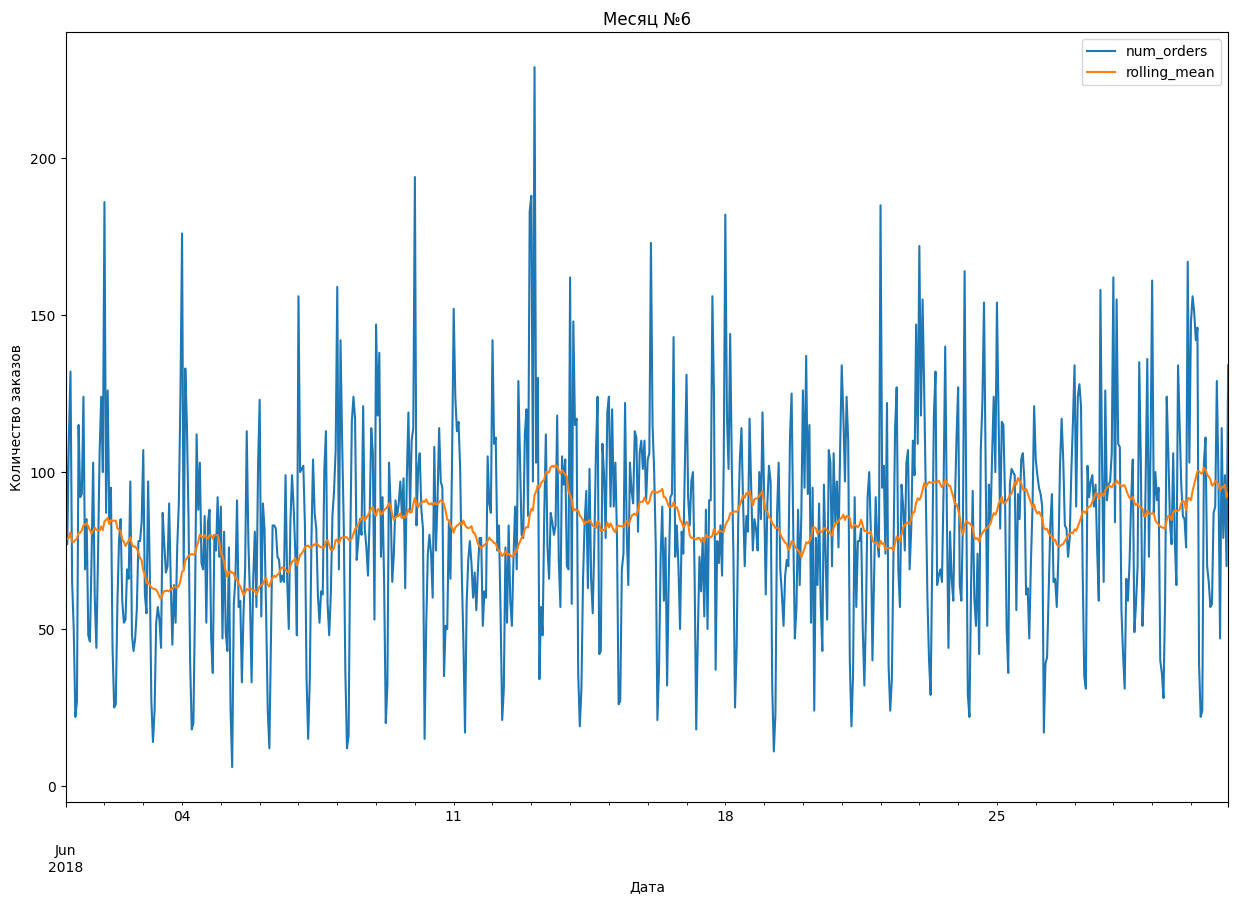

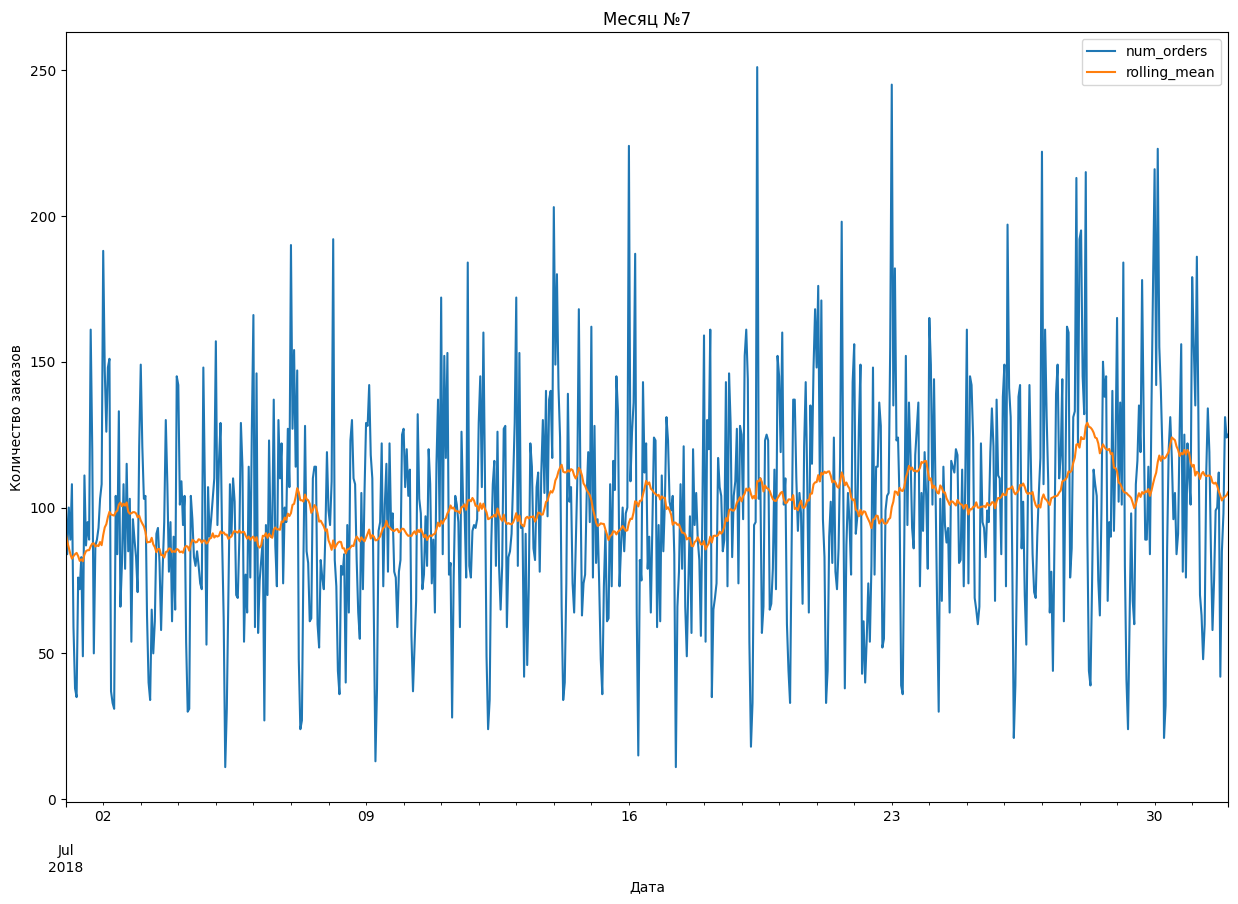

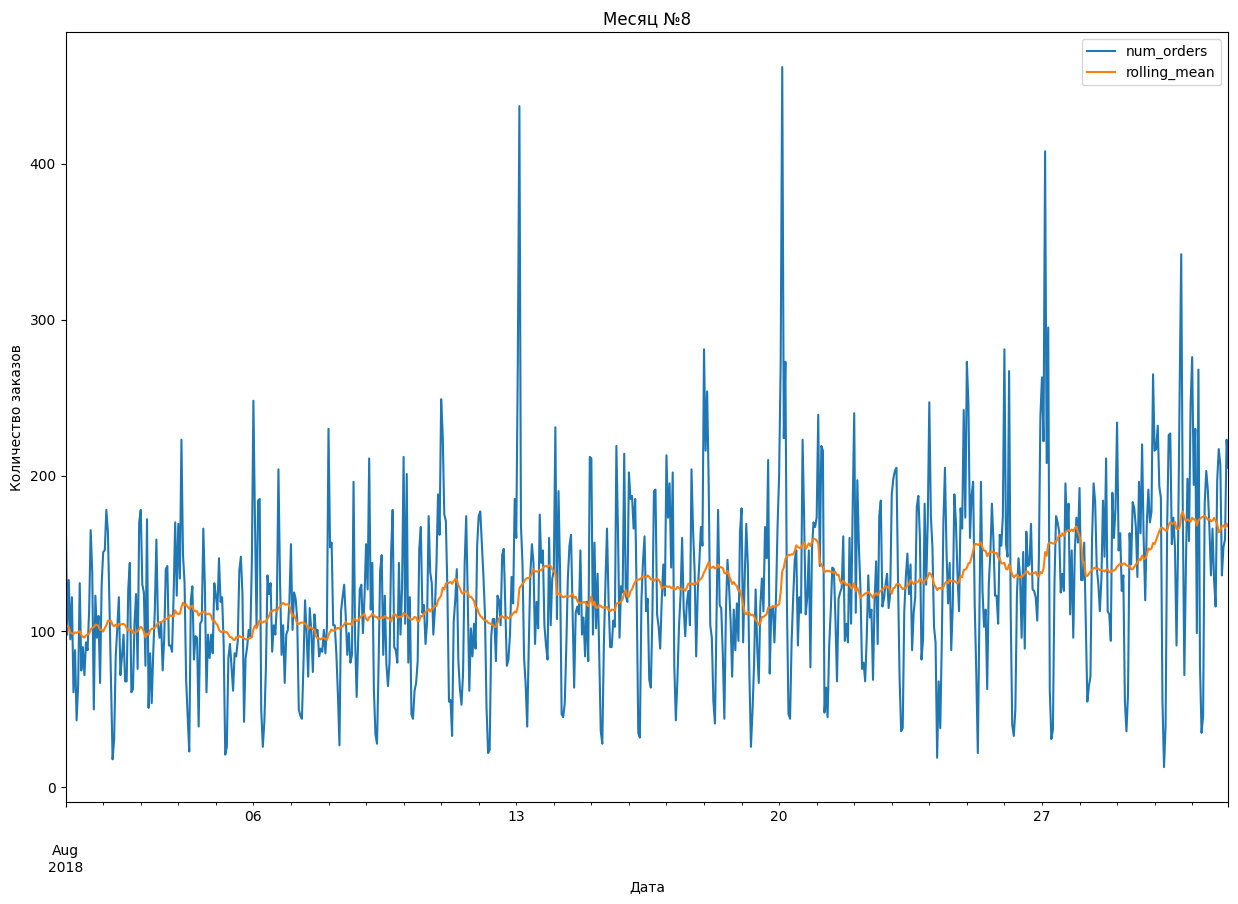

In [10]:
for m, ld in ((3, 31), (4, 30), (5, 31), (6,30), (7,31), (8, 31)):
    data[f'2018-{m:02d}-01':f'2018-{m:02d}-{ld}'].plot(figsize=(15, 10))
    plt.title(f'Месяц №{m}')
    plt.ylabel('Количество заказов')
    plt.xlabel('Дата')
    plt.show()

Прослеживается сезонность на отрезке в неделю + есть тренд на увеличение количества заказов к лету. Месяц и день недели обязательно надо добавить в признаки.

In [11]:
def seasonal_decompose_plot(
    df, 
    resample_period
):
    df = df.resample(resample_period).sum()
    
    decomposed = seasonal_decompose(df)

    plt.figure(figsize=(15, 20))

    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Тренд')

    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Сезонность')

    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Остатки')
    
    plt.tight_layout()
    
    plt.show()

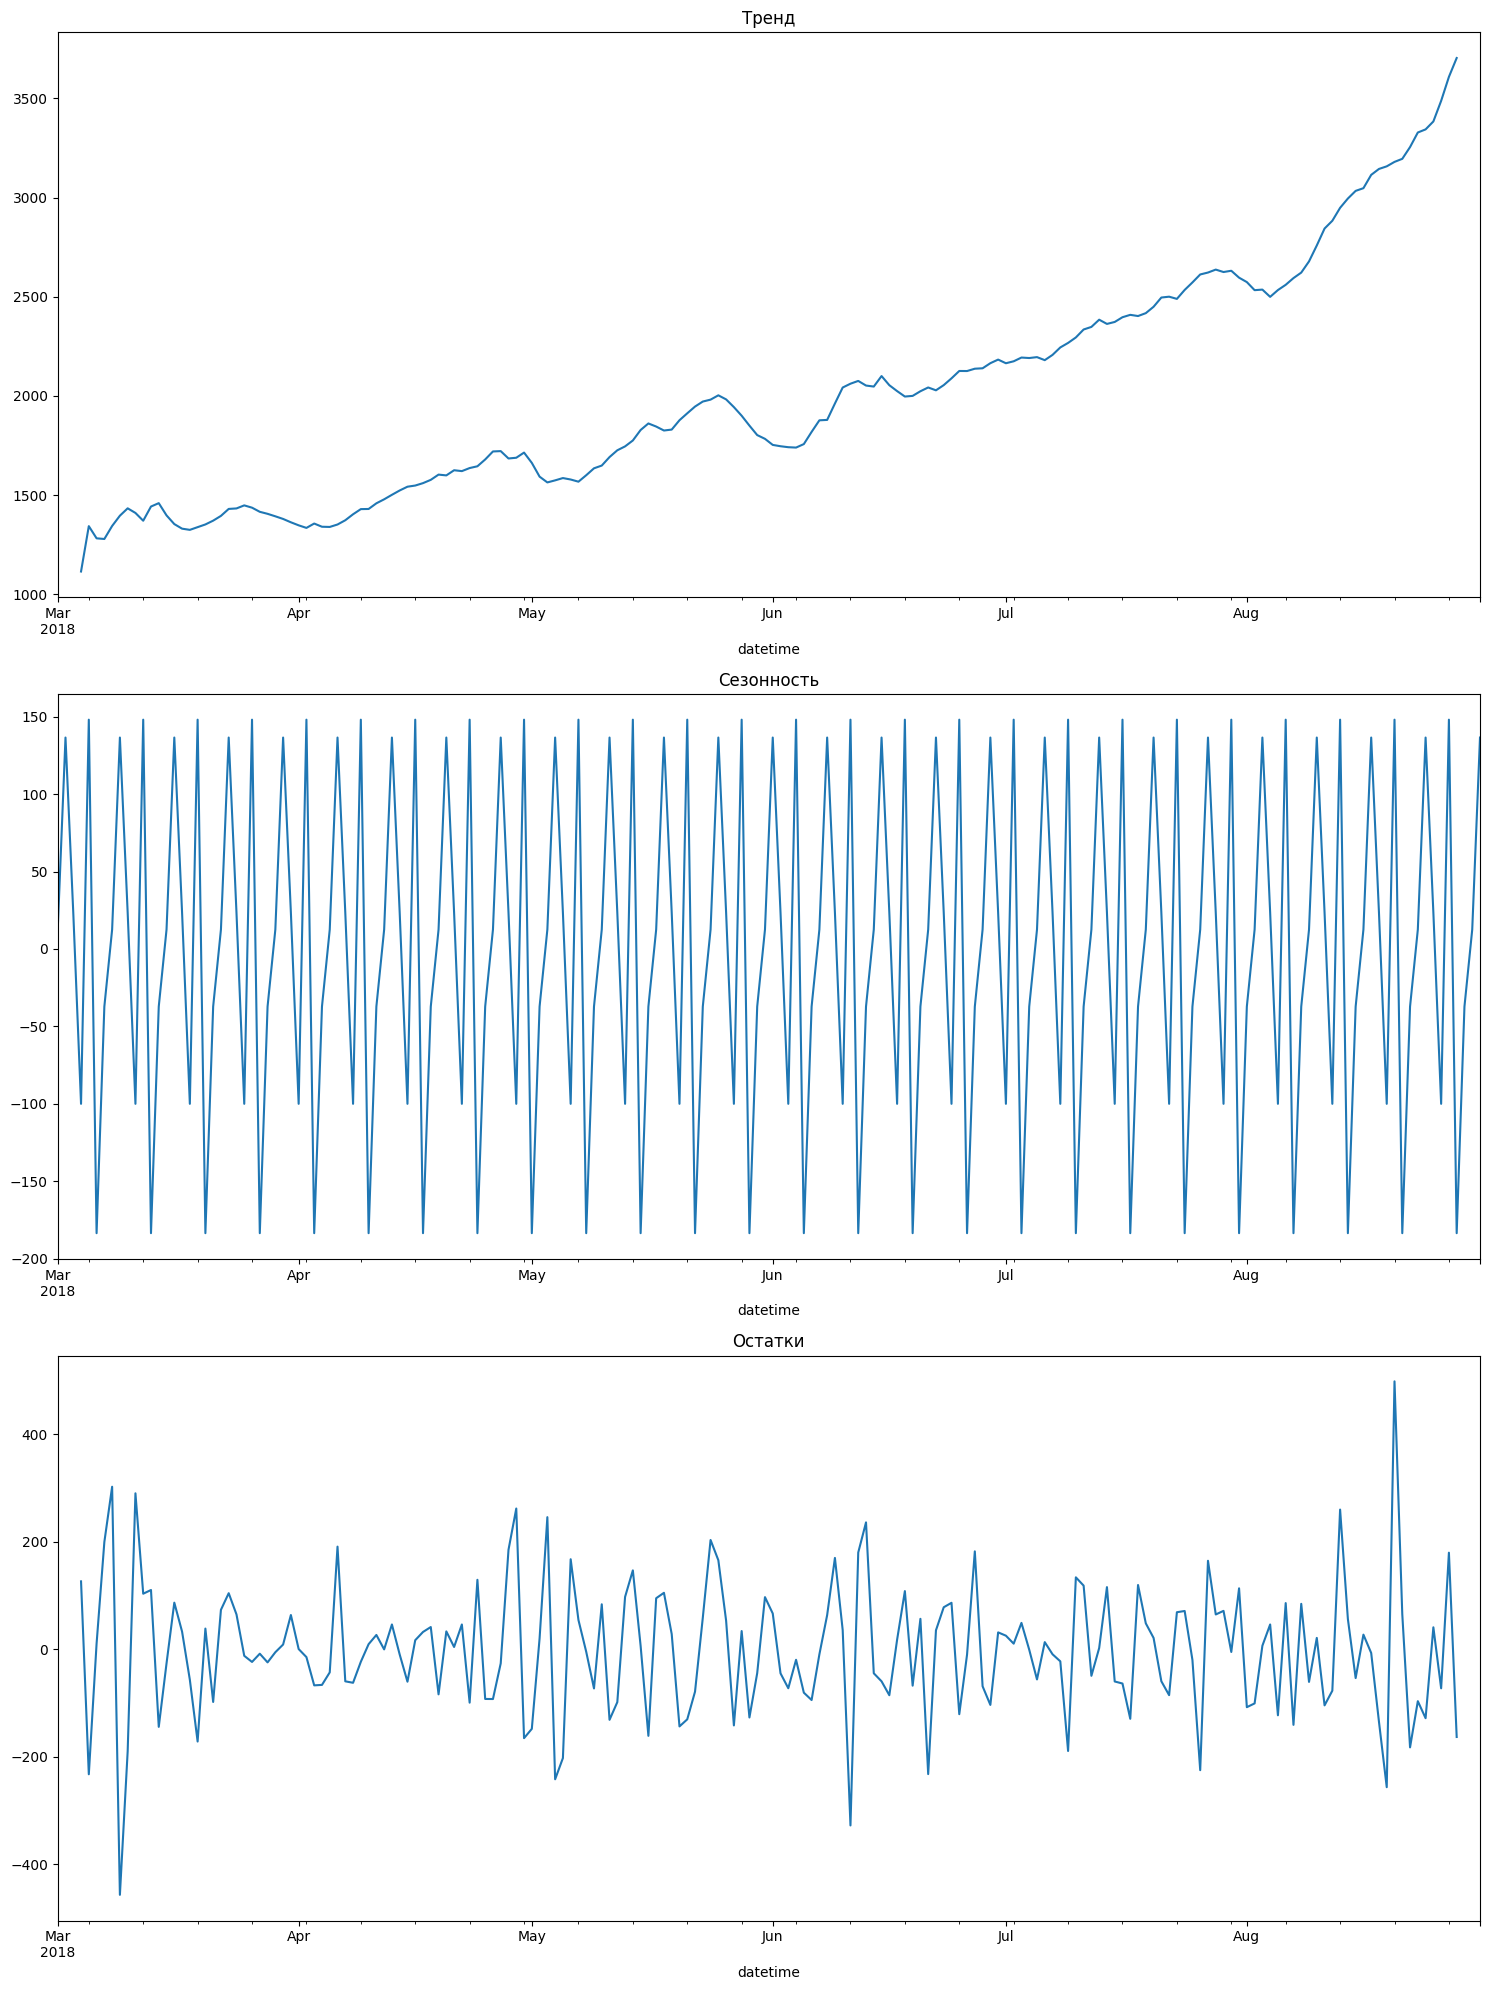

In [12]:
# ресемпл на день, посмотрим все данные
df = data.dropna().loc['2018-03-01':'2018-08-31','num_orders']
seasonal_decompose_plot(df, '1D')

Виден тренд к росту и недельная сезонность. Посмотрим ещё варианты

/tmp/ipykernel_74980/4184836664.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample(resample_period).sum()


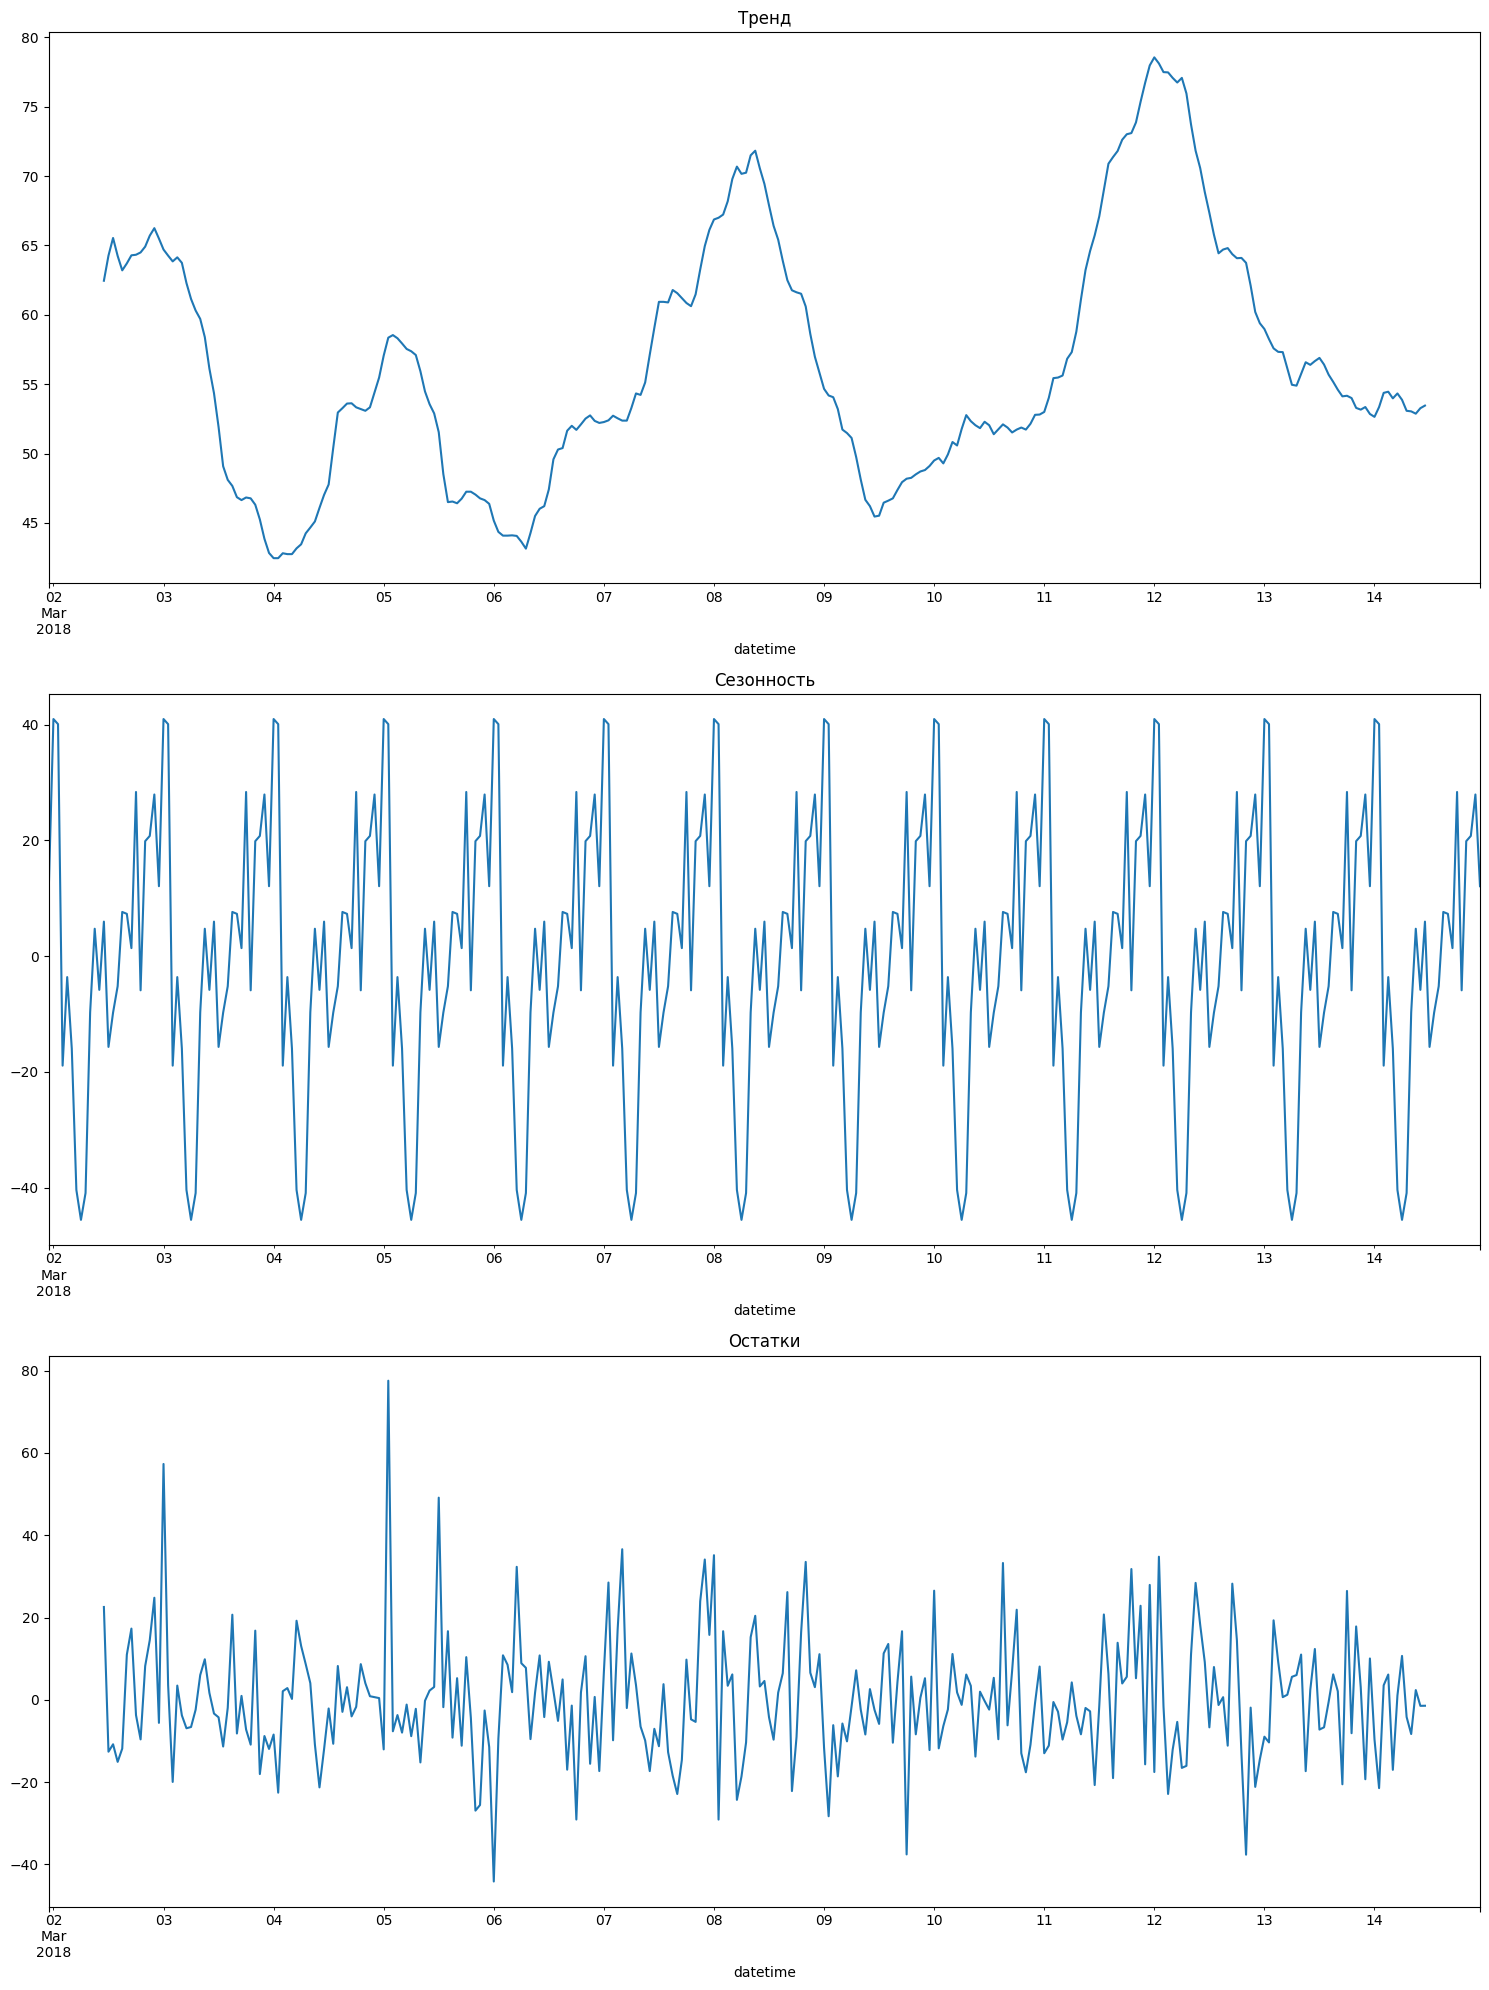

In [13]:
# ресемпл на час, посмотрим 1-14 марта
df = data.dropna().loc['2018-03-01':'2018-03-14','num_orders']
seasonal_decompose_plot(df, '1H')

/tmp/ipykernel_74980/4184836664.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample(resample_period).sum()


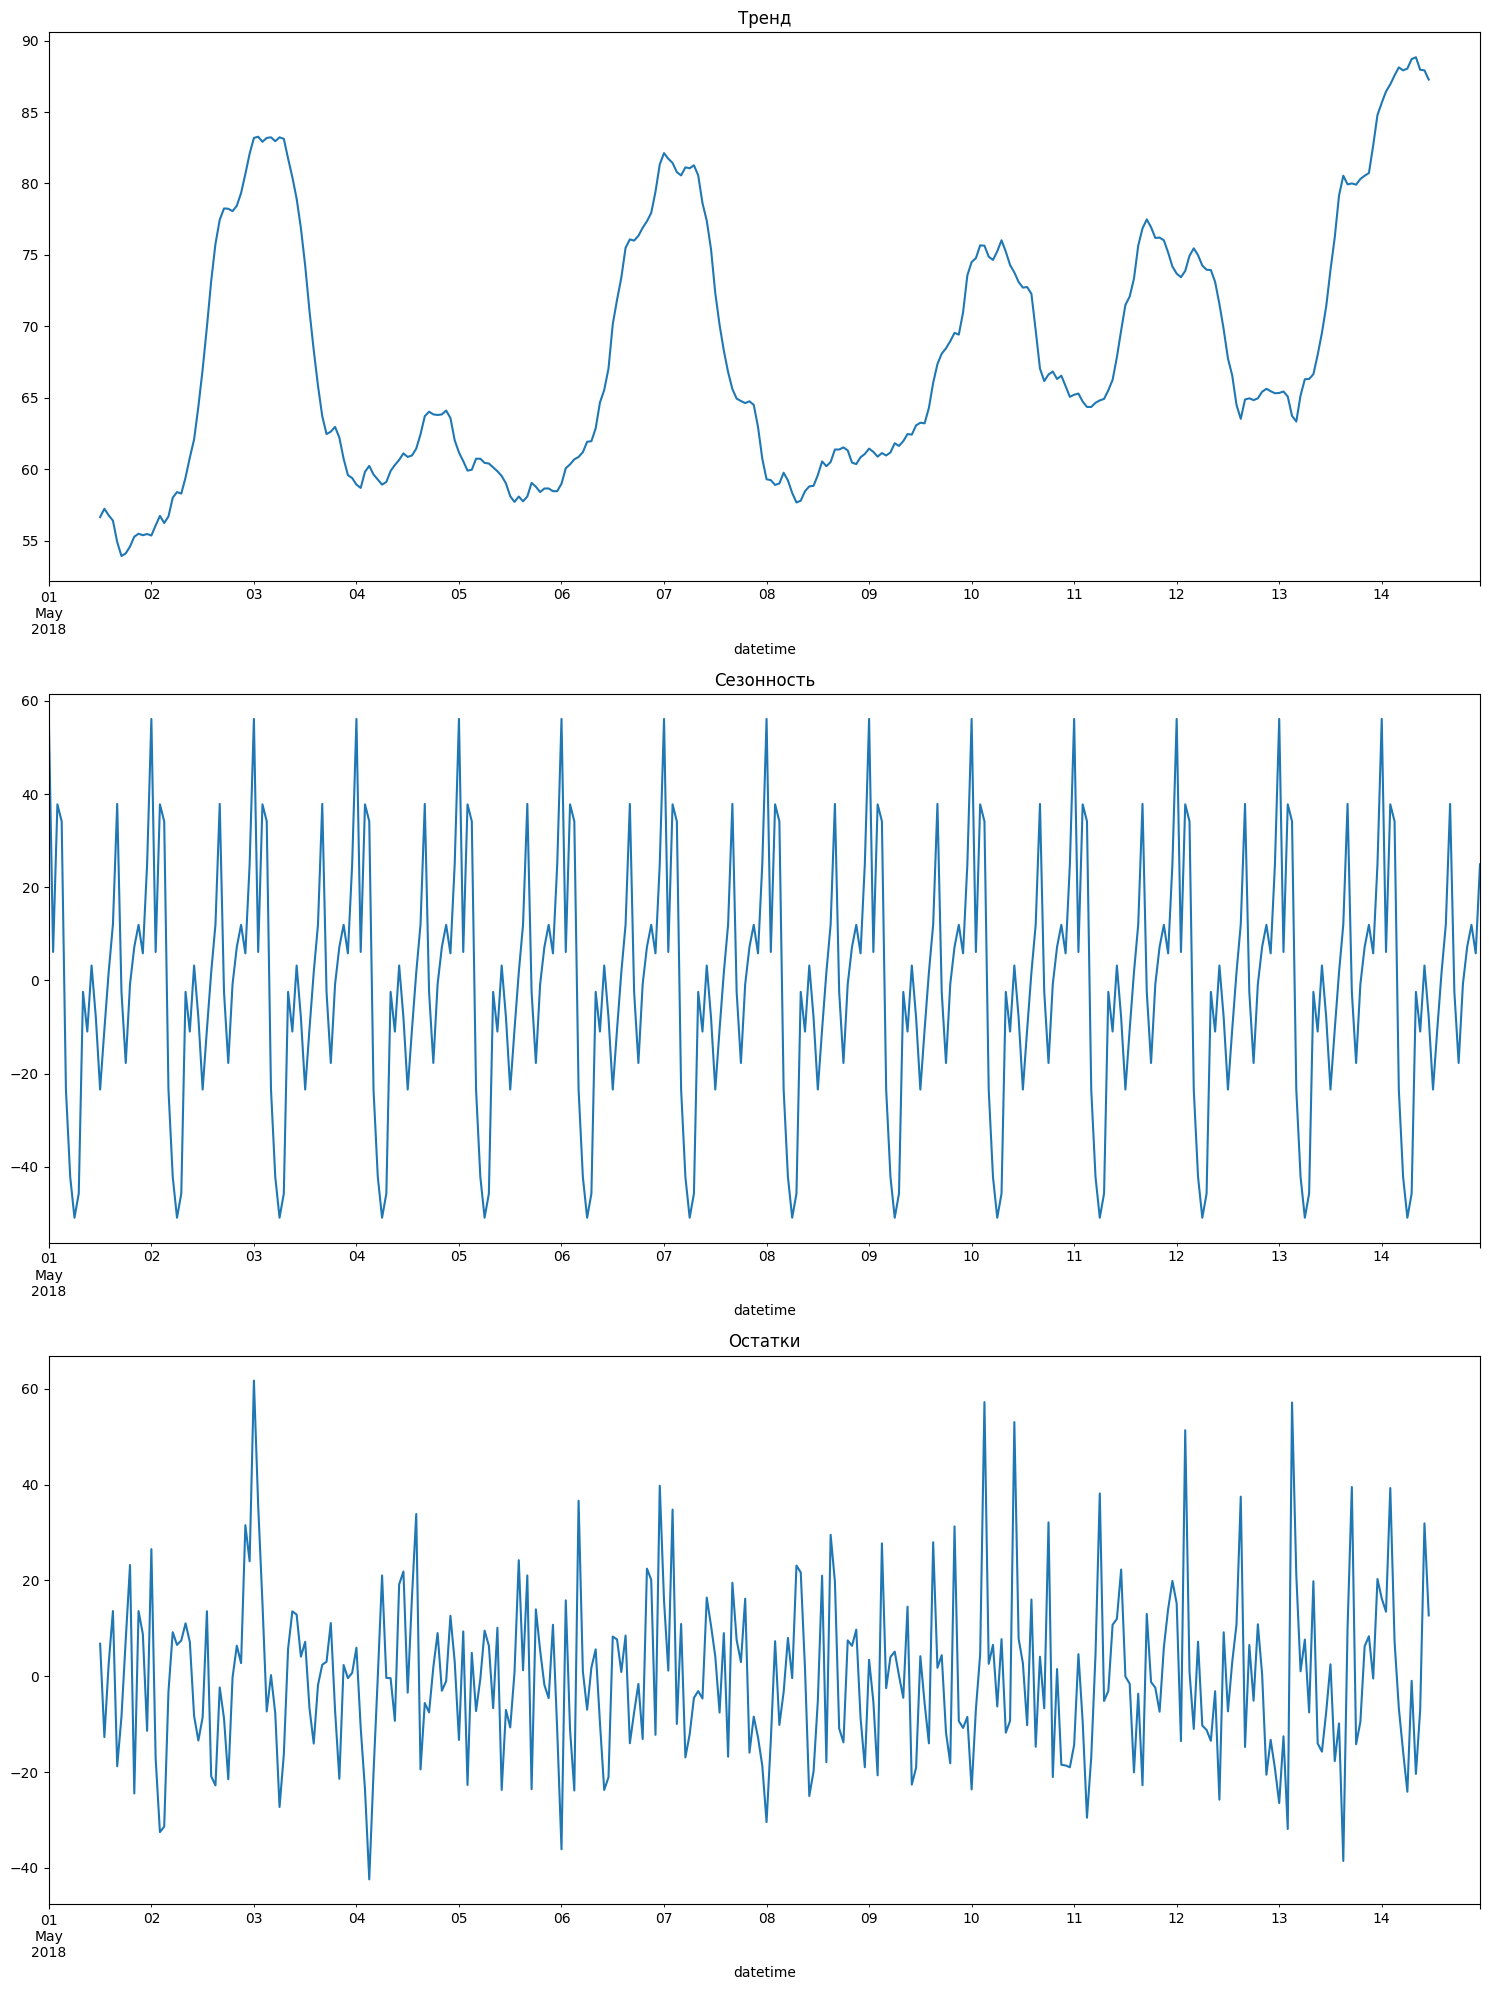

In [14]:
# ресемпл на час, посмотрим 1-14 мая
df = data.dropna().loc['2018-05-01':'2018-05-14','num_orders']
seasonal_decompose_plot(df, '1H')

/tmp/ipykernel_74980/4184836664.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample(resample_period).sum()


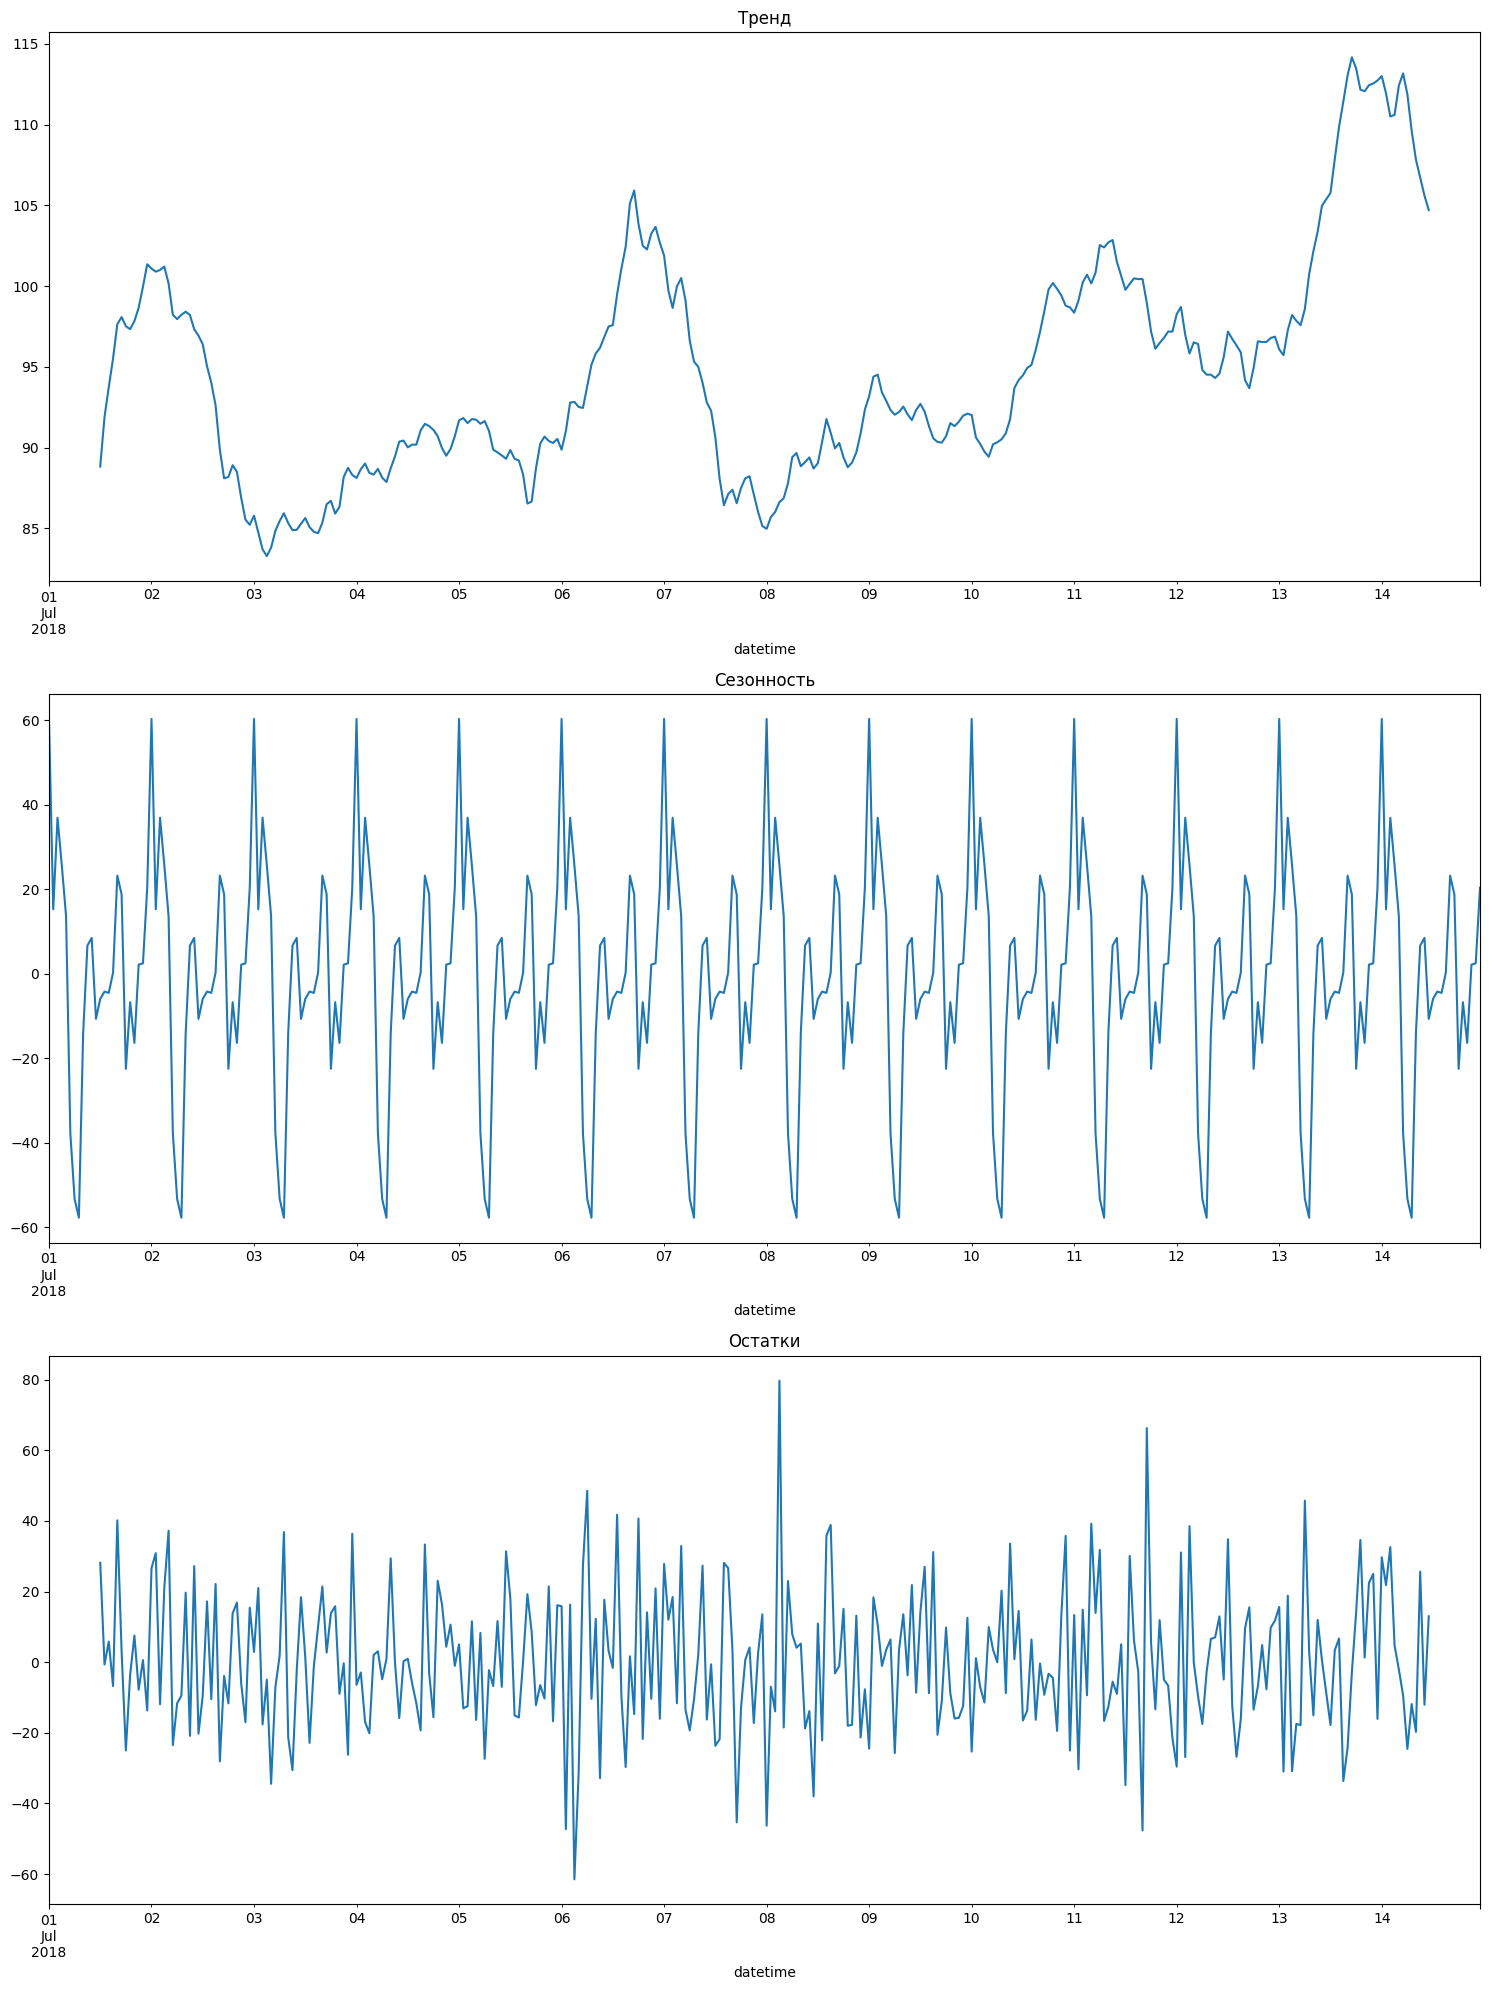

In [15]:
# ресемпл на час, посмотрим 1-14 июля
df = data.dropna().loc['2018-07-01':'2018-07-14','num_orders']
seasonal_decompose_plot(df, '1H')

За 2 недели особого тренда нет, но видна сезонность по часам - час действительно нужен в признаках

In [16]:
# удалим скользящее - в нём сейчас есть таргет
data.drop('rolling_mean', axis=1, inplace=True)

In [17]:
def add_features(
    df,
    rolling_mean_intervals,
    max_lag_hours
):
    tmp = df.copy()
    
    tmp['month'] = tmp.index.month
    tmp['day'] = tmp.index.day
    tmp['dayofweek'] = tmp.index.dayofweek
    tmp['hour'] = tmp.index.hour

    # скользящее за rolling_mean_intervals
    for h in rolling_mean_intervals:
        tmp[f'rolling_mean_{h}h'] = tmp['num_orders'].shift().rolling(h).mean()

    # лаг до max_lag_hours
    for l in range(1, max_lag_hours):
        tmp[f'lag_{l}'] = tmp['num_orders'].shift(l)

    return tmp

In [19]:
# добавим признаки
data_1 = add_features(data, [6, 12, 24], 25)
data_1.head(25)

num_orders  month  day  dayofweek  hour  rolling_mean_6h  \
datetime                                                                        
2018-03-01 00:00:00         124      3    1          3     0              NaN   
2018-03-01 01:00:00          85      3    1          3     1              NaN   
2018-03-01 02:00:00          71      3    1          3     2              NaN   
2018-03-01 03:00:00          66      3    1          3     3              NaN   
2018-03-01 04:00:00          43      3    1          3     4              NaN   
2018-03-01 05:00:00           6      3    1          3     5              NaN   
2018-03-01 06:00:00          12      3    1          3     6        65.833333   
2018-03-01 07:00:00          15      3    1          3     7        47.166667   
2018-03-01 08:00:00          34      3    1          3     8        35.500000   
2018-03-01 09:00:00          69      3    1          3     9        29.333333   
2018-03-01 10:00:00          64      3    1          3    10        29.833333   
2018-03-01 11:00:00          96      3    1          3    11        33.333333   
2018-03-01 12:00:00          30      3    1          3    12        48.333333   
2018-03-01 13:00:00          32      3    1          3    13        51.333333   
2018-03-01 14:00:00          48      3    1          3    14        54.166667   
2018-03-01 15:00:00          66      3    1          3    15        56.500000   
2018-03-01 16:00:00          43      3    1          3    16        56.000000   
2018-03-01 17:00:00          44      3    1          3    17        52.500000   
2018-03-01 18:00:00          73      3    1          3    18        43.833333   
2018-03-01 19:00:00          45      3    1          3    19        51.000000   
2018-03-01 20:00:00          61      3    1          3    20        53.166667   
2018-03-01 21:00:00          66      3    1          3    21        55.333333   
2018-03-01 22:00:00         113      3    1          3    22        55.333333   
2018-03-01 23:00:00          58      3    1          3    23        67.000000   
2018-03-02 00:00:00          90      3    2          4     0        69.333333   

                     rolling_mean_12h  rolling_mean_24h  lag_1  lag_2  ...  \
datetime                                                               ...   
2018-03-01 00:00:00               NaN               NaN    NaN    NaN  ...   
2018-03-01 01:00:00               NaN               NaN  124.0    NaN  ...   
2018-03-01 02:00:00               NaN               NaN   85.0  124.0  ...   
2018-03-01 03:00:00               NaN               NaN   71.0   85.0  ...   
2018-03-01 04:00:00               NaN               NaN   66.0   71.0  ...   
2018-03-01 05:00:00               NaN               NaN   43.0   66.0  ...   
2018-03-01 06:00:00               NaN               NaN    6.0   43.0  ...   
2018-03-01 07:00:00               NaN               NaN   12.0    6.0  ...   
2018-03-01 08:00:00               NaN               NaN   15.0   12.0  ...   
2018-03-01 09:00:00               NaN               NaN   34.0   15.0  ...   
2018-03-01 10:00:00               NaN               NaN   69.0   34.0  ...   
2018-03-01 11:00:00               NaN               NaN   64.0   69.0  ...   
2018-03-01 12:00:00         57.083333               NaN   96.0   64.0  ...   
2018-03-01 13:00:00         49.250000               NaN   30.0   96.0  ...   
2018-03-01 14:00:00         44.833333               NaN   32.0   30.0  ...   
2018-03-01 15:00:00         42.916667               NaN   48.0   32.0  ...   
2018-03-01 16:00:00         42.916667               NaN   66.0   48.0  ...   
2018-03-01 17:00:00         42.916667               NaN   43.0   66.0  ...   
2018-03-01 18:00:00         46.083333               NaN   44.0   43.0  ...   
2018-03-01 19:00:00         51.166667               NaN   73.0   44.0  ...   
2018-03-01 20:00:00         53.666667               NaN   45.0   73.0  ...   
2018-03-01 21:00:00         55.916667  

### Итог
Данные в порядке - аномалий в количестве заказов нет. 
Посмотрел тренд и сезонность для распределения по дням и часам, решил добавить признак.

## Обучение

In [20]:
train, test = train_test_split(data_1, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()

In [21]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [22]:
# приведём фичи к одному масштабу - на 3 порядка отличаются величины
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
pipe = Pipeline(
    [
        ('models', DummyRegressor())
    ]
)

In [24]:
param_grid = [
    
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': [0.1, 1., 10.]
    },
    
    {
        'models': [Lasso(random_state=RANDOM_STATE)],
        'models__alpha': [0.1, 1., 10.]
    },
    
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [5, 7, 9],
        'models__min_samples_leaf': [2, 3, 4]
    },
    
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [5, 7, 9],
        'models__min_samples_leaf': [2, 3, 4]
    }
]

In [25]:
grid = GridSearchCV(
    pipe, 
    param_grid, 
    cv=TimeSeriesSplit(),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

In [26]:
grid.fit(X_train, y_train)

/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3153
[LightGBM] [Info] Number of data points in the train set: 660, number of used features: 30
[LightGBM] [Info] Start training from score 57.103030
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.244658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3877
[LightGBM] [Info] Number of data points in the train set: 1318, number of used features: 31
[LightGBM] [Info] Start training from score 59.327769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3153
[LightGBM] [Info] Number of data points in the train set: 660, number of used features: 30
[LightGBM] [Info] Start training from score 57.103030
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4983
[LightGBM] [Info] Number of data points in the train set: 3292, number of used features: 31
[LightGBM] [Info] Start training from score 72.570170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4254
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 31
[LightGBM] [Info] Start training from score 63.373482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3877
[LightGBM] [Info] Number of data points in the train set: 1318, number of used features: 31
[LightGBM] [Info] Start training from score 59.327769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3877
[LightGBM] [Info] Number of data points in the train set: 1318, number of used features: 31
[LightGBM] [Info] Start training from score 59.327769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4599
[LightGBM] [Info] Number of data points in the train set: 2634, number of used features: 31
[LightGBM] [Info] Start training from score 67.753227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4254
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 31
[LightGBM] [Info] Start training from score 63.373482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4254
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 31
[LightGBM] [Info] Start training from score 63.373482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.200542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3153
[LightGBM] [Info] Number of data points in the train set: 660, number of used features: 30
[LightGBM] [Info] Start training from score 57.103030
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5383
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 31
[LightGBM] [Info] Start training from score 78.421013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('models', DummyRegressor())]),
             n_jobs=-1,
             param_grid=[{'models': [Ridge(random_state=42)],
                          'models__alpha': [0.1, 1.0, 10.0]},
                         {'models': [Lasso(random_state=42)],
                          'models__alpha': [0.1, 1.0, 10.0]},
                         {'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': [5, 7, 9],
                          'models__min_samples_leaf': [2, 3, 4]},
                         {'models': [LGBMRegressor(random_state=42)],
                          'models__max_depth': [5, 7, 9],
                          'models__min_samples_leaf': [2, 3, 4]}],
             scoring='neg_root_mean_squared_error')

In [27]:
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
17     346.560736     37.531520         0.055628        0.015139   
16     362.924319     33.360704         0.048687        0.011884   
20     496.570758     33.662036         0.038125        0.011745   
22     521.404016     73.628268         0.035605        0.016211   
15     392.623500     26.437797         0.040211        0.013395   
23     405.479189     86.720356         0.013050        0.008910   
21     465.948334     99.887486         0.033173        0.022728   
19     525.495098     21.734244         0.051230        0.010274   
18     539.431263     14.605097         0.056857        0.013712   
1        0.004929      0.001073         0.001524        0.000204   

                      param_models  param_models__alpha  \
17  LGBMRegressor(random_state=42)                  NaN   
16  LGBMRegressor(random_state=42)                  NaN   
20  LGBMRegressor(random_state=42)                  NaN   
22  LGBMRegressor(random_state=42)                  NaN   
15  LGBMRegressor(random_state=42)                  NaN   
23  LGBMRegressor(random_state=42)                  NaN   
21  LGBMRegressor(random_state=42)                  NaN   
19  LGBMRegressor(random_state=42)                  NaN   
18  LGBMRegressor(random_state=42)                  NaN   
1           Ridge(random_state=42)                  1.0   

    param_models__max_depth  param_models__min_samples_leaf  \
17                      5.0                             4.0   
16                      5.0                             3.0   
20                      7.0                             4.0   
22                      9.0                             3.0   
15                      5.0                             2.0   
23                      9.0                             4.0   
21                      9.0                             2.0   
19                      7.0                             3.0   
18                      7.0                             2.0   
1                       NaN                             NaN   

                                               params  split0_test_score  \
17  {'models': LGBMRegressor(random_state=42), 'mo...         -21.603011   
16  {'models': LGBMRegressor(random_state=42), 'mo...         -21.897081   
20  {'models': LGBMRegressor(random_state=42), 'mo...         -22.292934   
22  {'models': LGBMRegressor(random_state=42), 'mo...         -22.067513   
15  {'models': LGBMRegressor(random_state=42), 'mo...         -21.941364   
23  {'models': LGBMRegressor(random_state=42), 'mo...         -22.312933   
21  {'models': LGBMRegressor(random_state=42), 'mo...         -22.381385   
19  {'models': LGBMRegressor(random_state=42), 'mo...         -22.514224   
18  {'models': LGBMRegressor(random_state=42), 'mo...         -22.420627   
1   {'models': Ridge(random_state=42), 'models__al...         -23.886048   

    split1_test_score  split2_test_score  split3_test_score  \
17         -21.624958         -23.412230         -25.273815   
16         -21.717548         -23.886622         -25.020738   
20         -22.216956         -23.714381         -25.534434   
22         -22.375523         -23.979955         -25.303106   
15         -22.459427         -24.106661         -25.092428   
23         -22.469502         -23.695314         -25.432532   
21         -22.225826         -23.894268         -25.256491   
19         -22.114088         -24.260686         -25.333824   
18         -22.745893         -23.924643         -25.462930   
1          -24.346669         -25.413382         -27.246768   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
17         -31.711929       -24.725189        3.746967                1  
16         -31.389335       -24.782265        3.527866                2  
20         -31.115813       -24.974904        3.298848                3  
22         -31.371202       -25.019460        3.382604                4  
15        

### Итог
Обучили модели, лучшую модель и гиперпараметры выбрали с помощью GridSearchCV.
На удивление LGBMRegressor не сильно обгоняет Ridge на обучающей.

## Тестирование

In [28]:
y_test_pred = grid.predict(X_test)
rmse_test = root_mean_squared_error(y_test, y_test_pred)
print(f'RMSE на тестовой выборке: {rmse_test:.1f}')

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
RMSE на тестовой выборке: 40.8


/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/tmp/ipykernel_74980/875151884.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tmp.resample(interval).sum().plot(figsize=(15, 10))


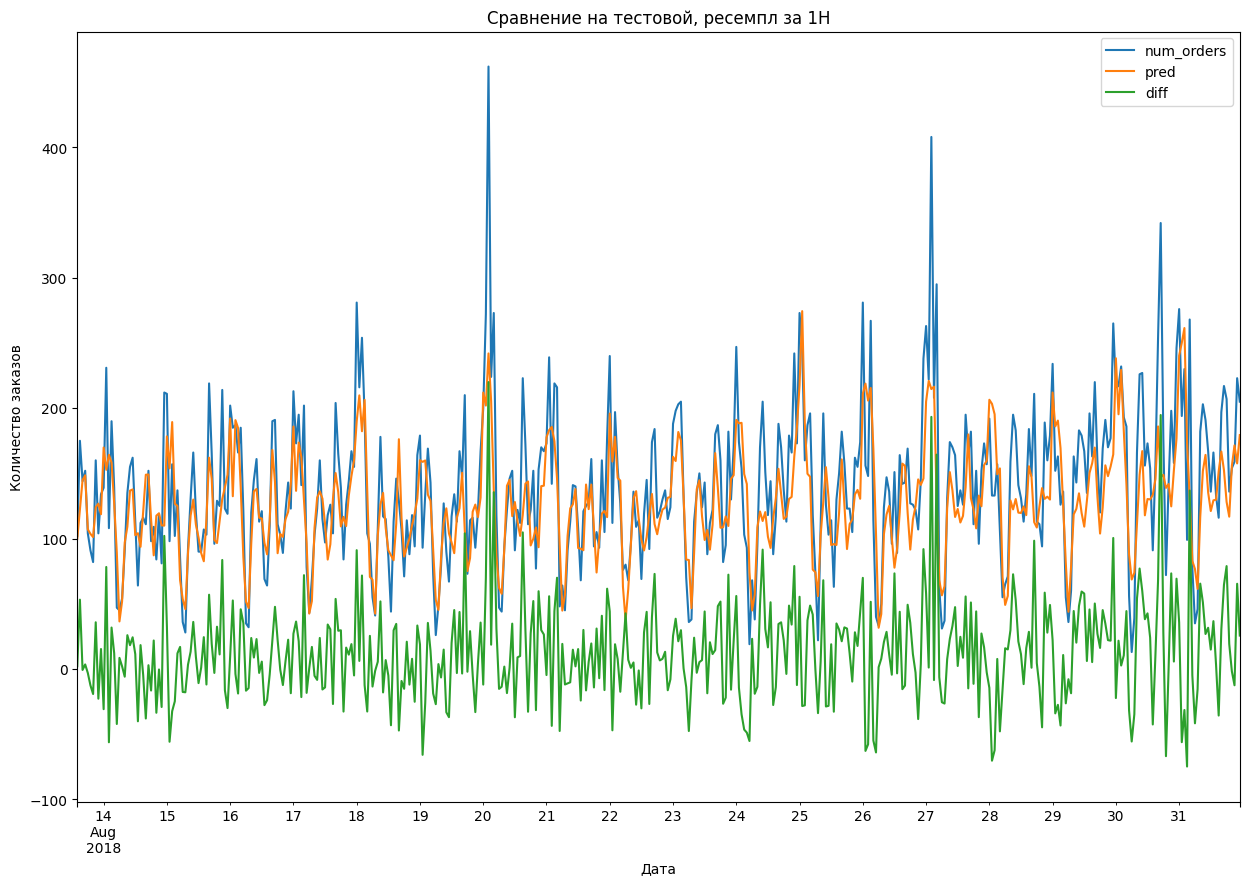

/tmp/ipykernel_74980/875151884.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tmp.resample(interval).sum().plot(figsize=(15, 10))


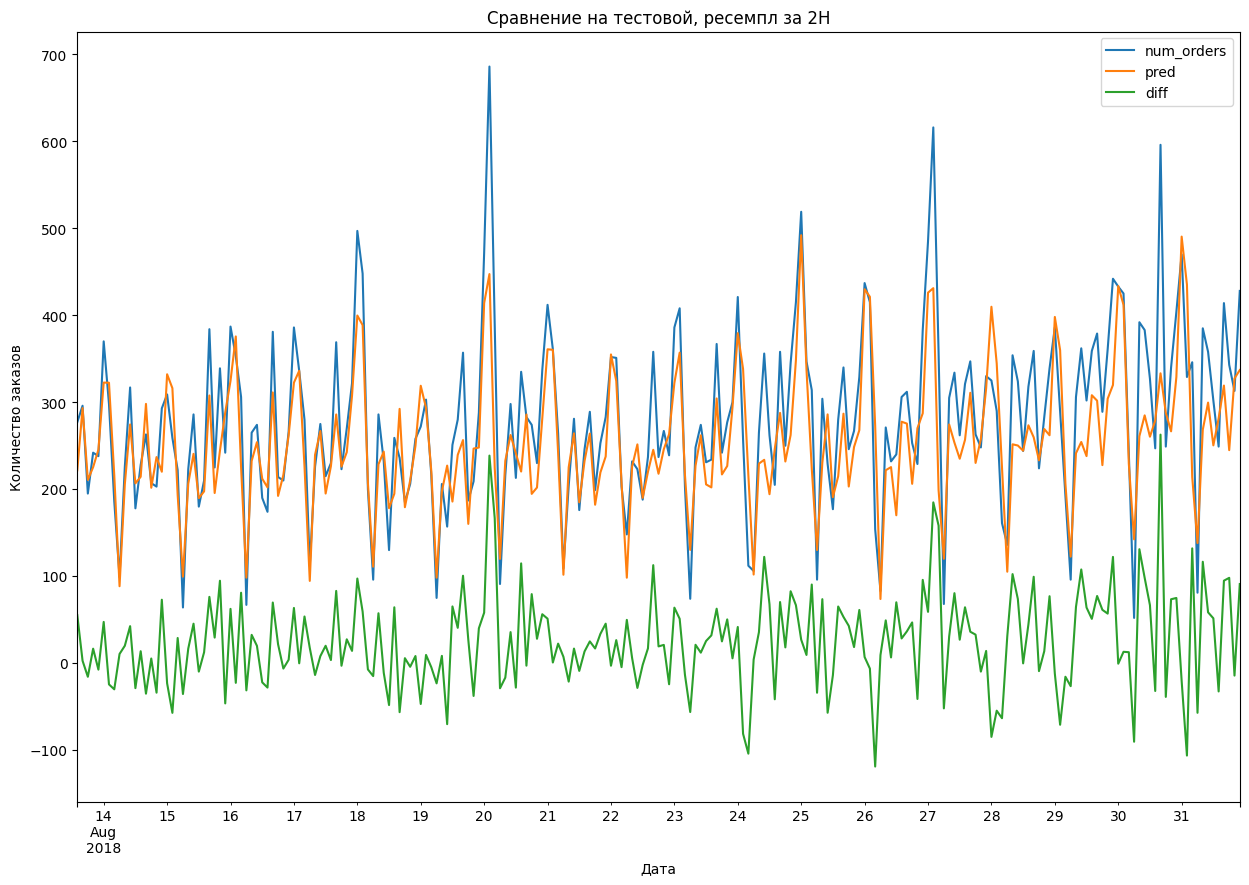

/tmp/ipykernel_74980/875151884.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tmp.resample(interval).sum().plot(figsize=(15, 10))


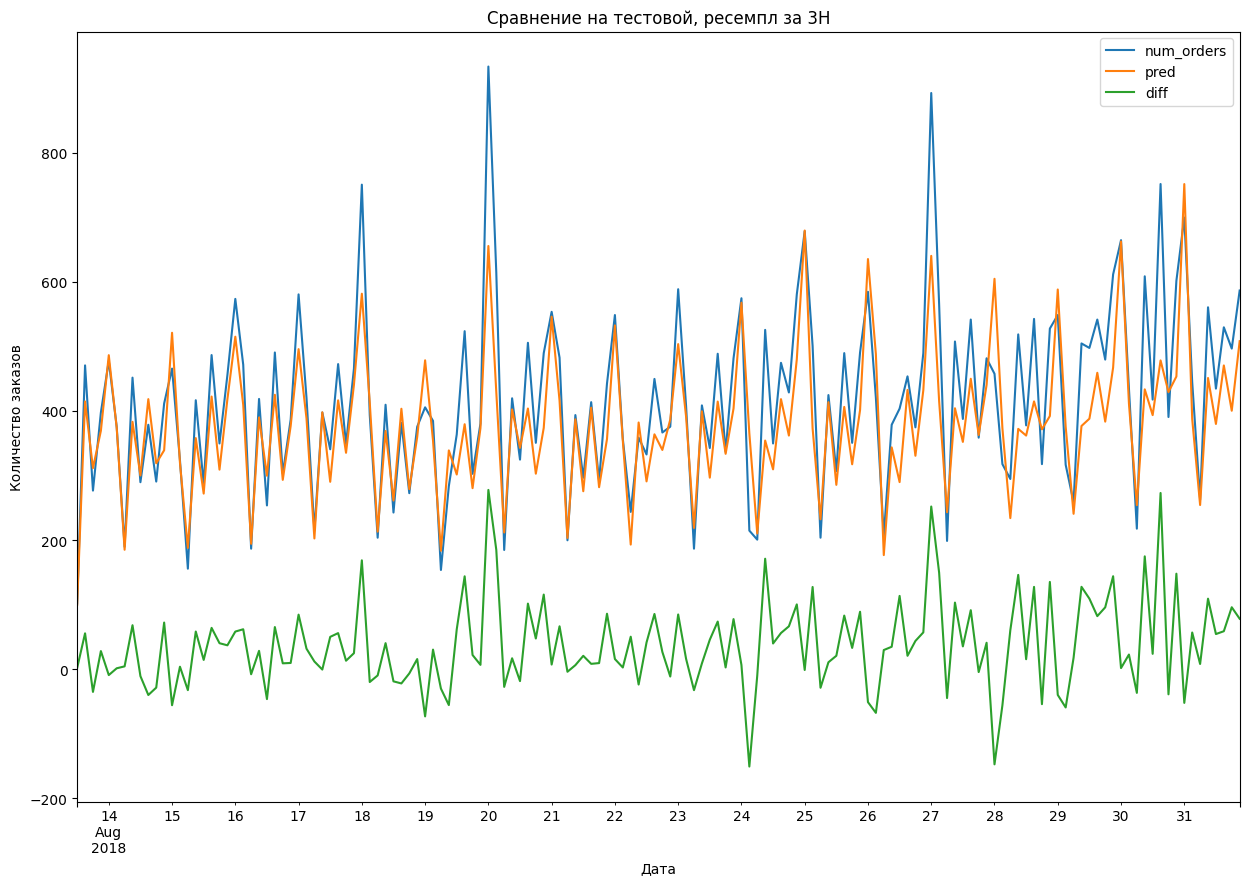

/tmp/ipykernel_74980/875151884.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tmp.resample(interval).sum().plot(figsize=(15, 10))


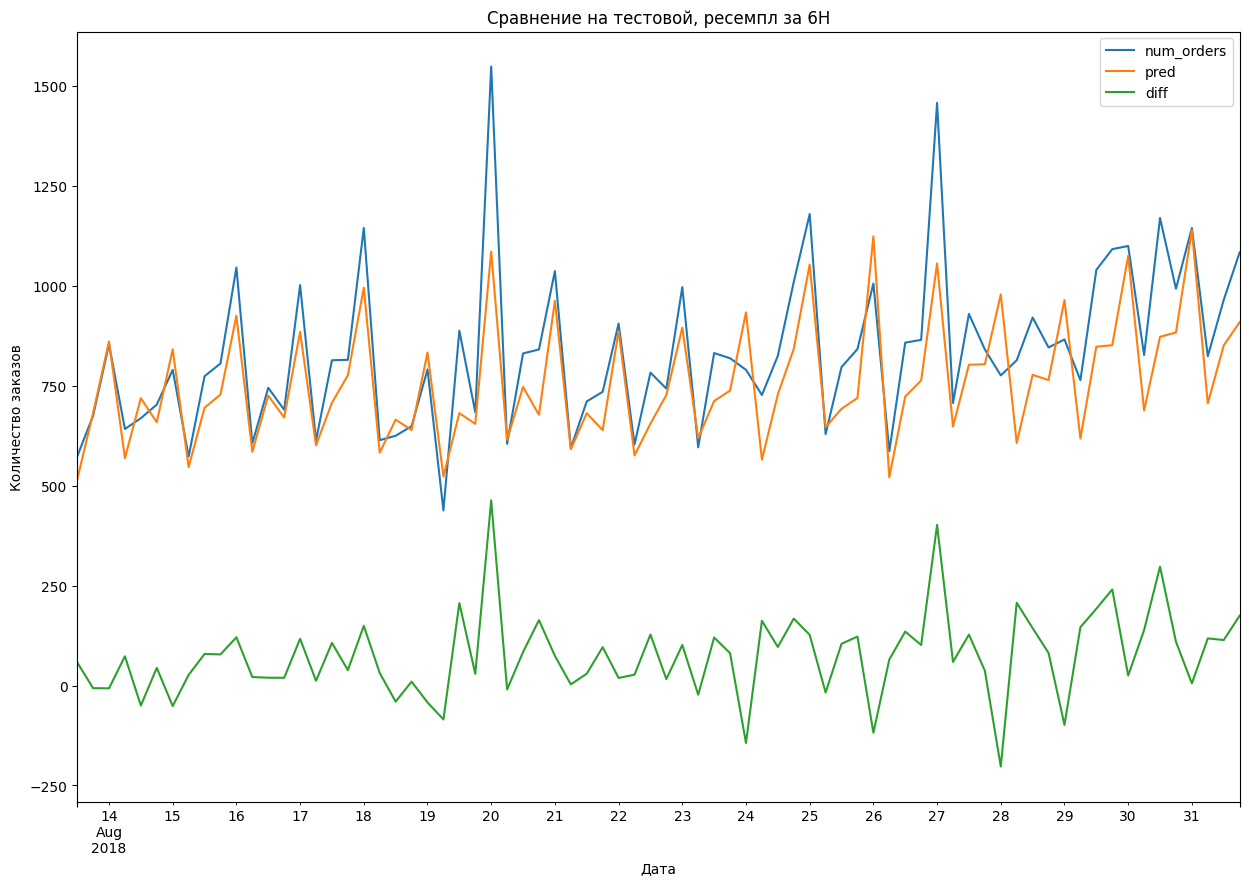

/tmp/ipykernel_74980/875151884.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tmp.resample(interval).sum().plot(figsize=(15, 10))


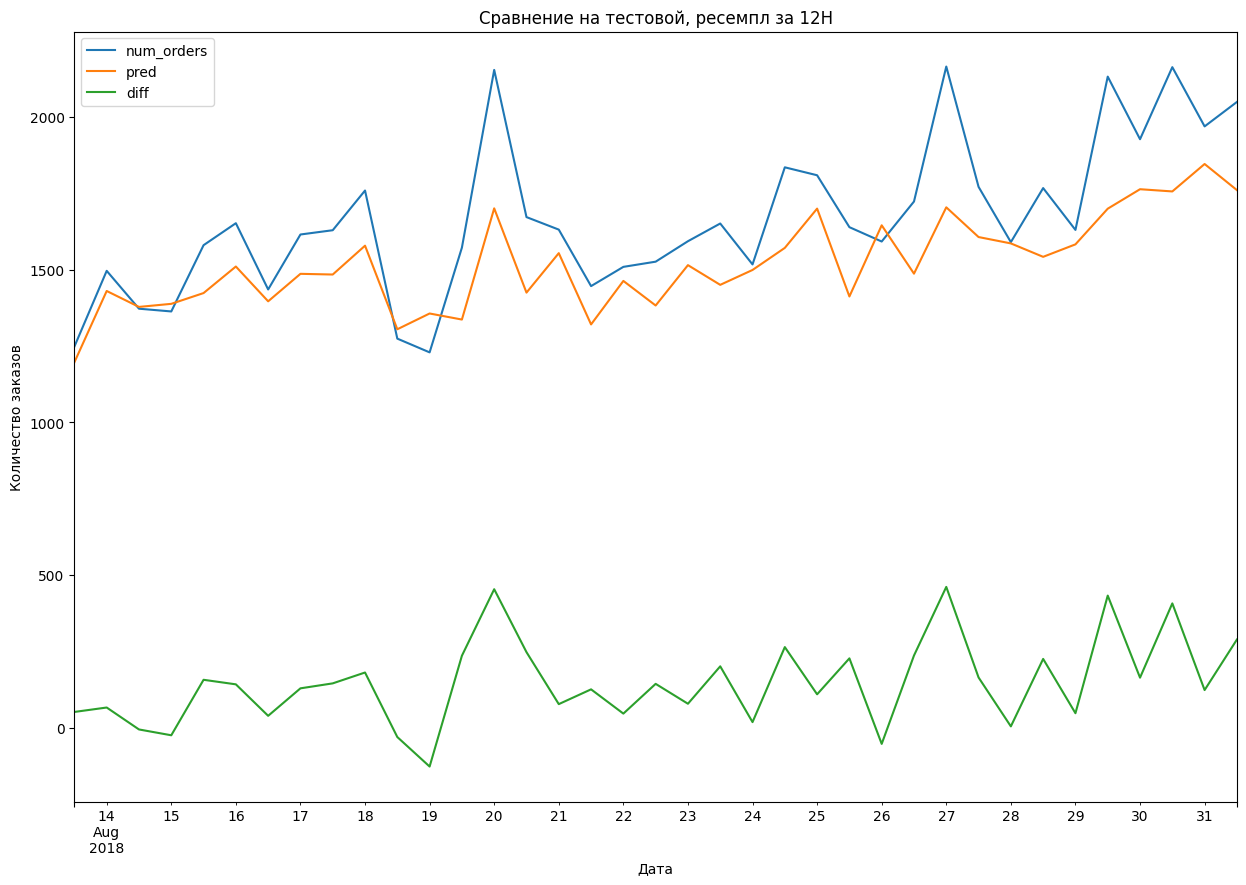

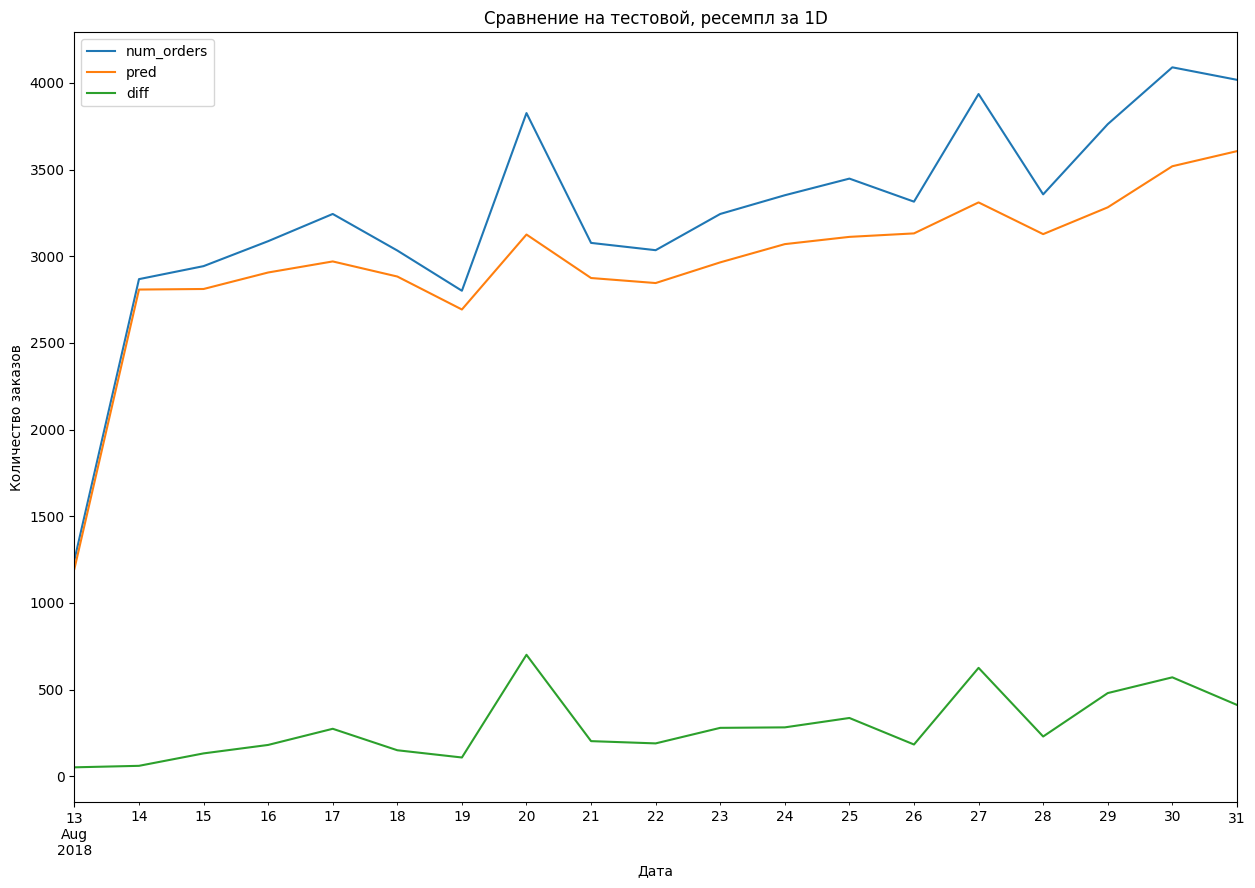

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4599
[LightGBM] [Info] Number of data points in the train set: 2634, number of used features: 31
[LightGBM] [Info] Start training from score 67.753227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [29]:
tmp = pd.DataFrame(y_test)
tmp['pred'] = y_test_pred
tmp['diff'] = tmp.num_orders - tmp.pred

for interval in '1H', '2H', '3H', '6H', '12H', '1D':
    tmp.resample(interval).sum().plot(figsize=(15, 10))
    plt.title(f'Сравнение на тестовой, ресемпл за {interval}')
    plt.ylabel('Количество заказов')
    plt.xlabel('Дата')
    plt.show()

На отрезке в 1 час модель работает вполне прилично, но есть отдельные выбросы/расхождения. 
На более длинных отрезках они сглаживаются.

### Итог
На тестовой метрика ощутимо ниже целевых 48.